In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import os
import hashlib
from PIL import Image
import numpy as np
import pandas as pd


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_dir = '/content/drive/MyDrive/PRIYANSHI DATASET'
train_dir = base_dir + '/train'
val_dir = base_dir + '/val'
test_dir = base_dir + '/test'

In [4]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [5]:
train = data(train_dir)
val = data(val_dir)
test = data(test_dir)

In [6]:
import os

def count_classes(directory):
  class_counts = {}

  for class_name in os.listdir(directory):
    class_path = os.path.join(directory, class_name)
    if os.path.isdir(class_path):
      class_counts[class_name] = len(os.listdir(class_path))
  return class_counts

train_counts = count_classes(train_dir)
val_counts = count_classes(val_dir)
test_counts = count_classes(test_dir)

print("Training set distribution:", train_counts)
print("Validation set distribution:", val_counts)
print("Test set distribution:", test_counts)


Training set distribution: {'fractured': 2079, 'not fractured': 2043}
Validation set distribution: {'fractured': 169, 'not fractured': 237}
Test set distribution: {'fractured': 200, 'not fractured': 201}


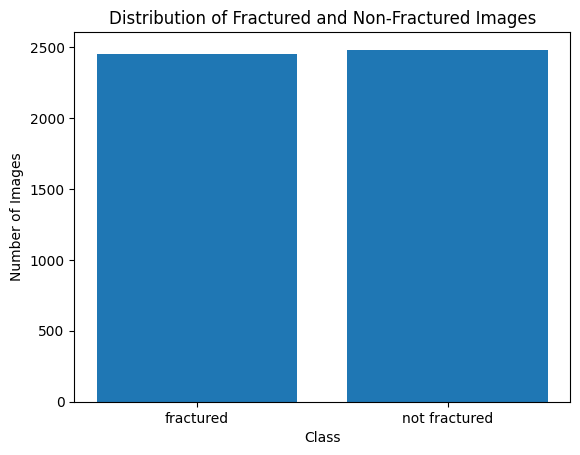

fractured: 2448 images
not fractured: 2481 images


In [7]:
import matplotlib.pyplot as plt
all_counts = {'fractured': train_counts.get('fractured', 0) + val_counts.get('fractured', 0) + test_counts.get('fractured', 0),
              'not fractured': train_counts.get('not fractured', 0) + val_counts.get('not fractured', 0) + test_counts.get('not fractured', 0)}
plt.bar(all_counts.keys(), all_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Fractured and Non-Fractured Images')
plt.show()
for class_name, count in all_counts.items():
    print(f"{class_name}: {count} images")

In [8]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

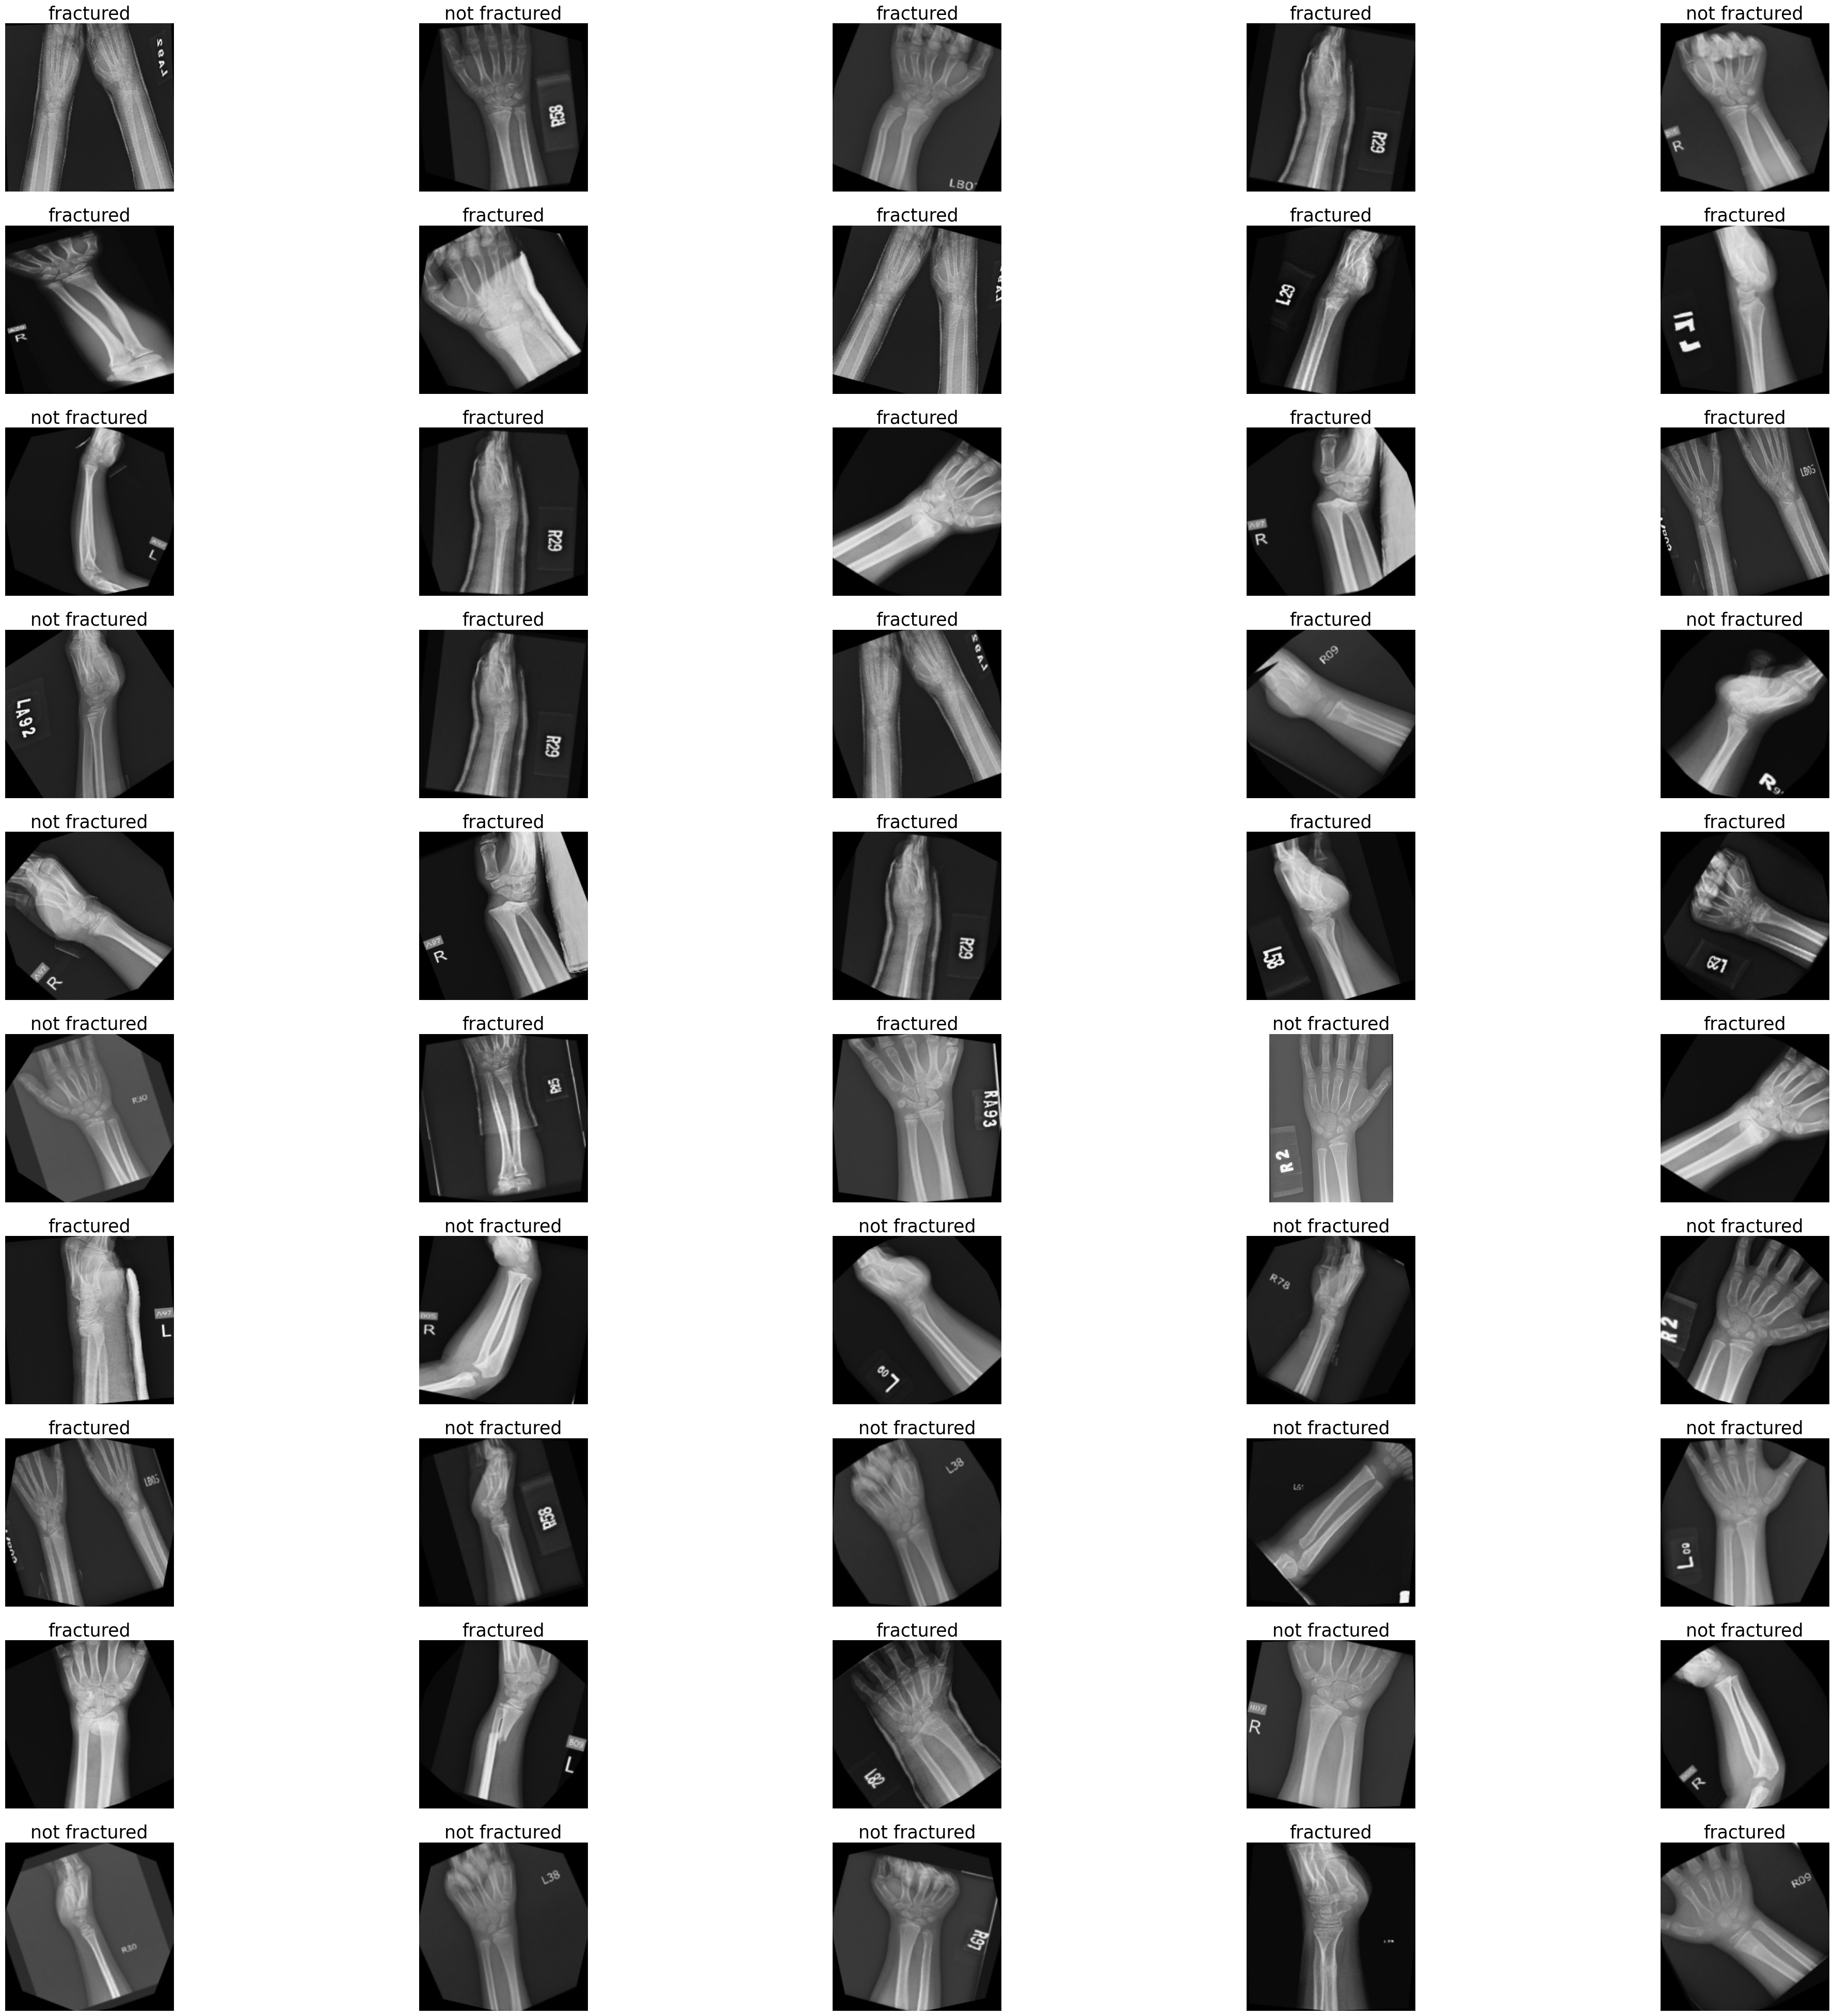

In [9]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

In [10]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 4120 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


In [11]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_base_model.layers:
    layer.trainable = False

resnet_model = Sequential()
resnet_model.add(resnet_base_model)
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

resnet_history = resnet_model.fit(train_generator, epochs=10, validation_data=val_generator)

# Fine-tuning ResNet50 model by unfreezing some layers
for layer in resnet_base_model.layers[-10:]:
    layer.trainable = True

resnet_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

fine_tuned_resnet_history = resnet_model.fit(train_generator, epochs=10, validation_data=val_generator)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 931s 7s/step - accuracy: 0.5198 - loss: 0.7068 - val_accuracy: 0.4158 - val_loss: 0.7151
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.5662 - loss: 0.6750 - val_accuracy: 0.6782 - val_loss: 0.6632
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.6282 - loss: 0.6610 - val_accuracy: 0.6708 - val_loss: 0.6550
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.6260 - loss: 0.6497 - val_accuracy: 0.7401 - val_loss: 0.6324
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.6500 - loss: 0.6453 - val_accuracy: 0.7698 - val_loss: 0.6282
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.6545 - loss: 0.6390 - val_accuracy: 0.7302 - val_loss: 0.6122
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.6641 - loss: 0.6285 - val_accuracy: 0.7277 - val_loss: 0.6019
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.6289 - loss: 0.6

In [13]:
# Evaluate ResNet50 model on the test set
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score # Import necessary functions

test_loss, test_accuracy = resnet_model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

test_preds = resnet_model.predict(test_generator)
test_preds = (test_preds > 0.5).astype(int)  # Use the built-in 'int'

test_labels = test_generator.classes

print('Classification Report')
print(classification_report(test_labels, test_preds, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
print(confusion_matrix(test_labels, test_preds))

accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)

print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 125s 10s/step - accuracy: 0.9692 - loss: 0.0979
Test loss: 0.09152279049158096
Test accuracy: 0.9674185514450073
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 409ms/step
Classification Report
               precision    recall  f1-score   support

    fractured       0.99      0.94      0.97       199
not fractured       0.95      0.99      0.97       200

     accuracy                           0.97       399
    macro avg       0.97      0.97      0.97       399
 weighted avg       0.97      0.97      0.97       399

Confusion Matrix
[[188  11]
 [  2 198]]
Accuracy: 0.9674185463659147
F1 score: 0.9682151589242054
Precision: 0.9473684210526315
Recall: 0.99


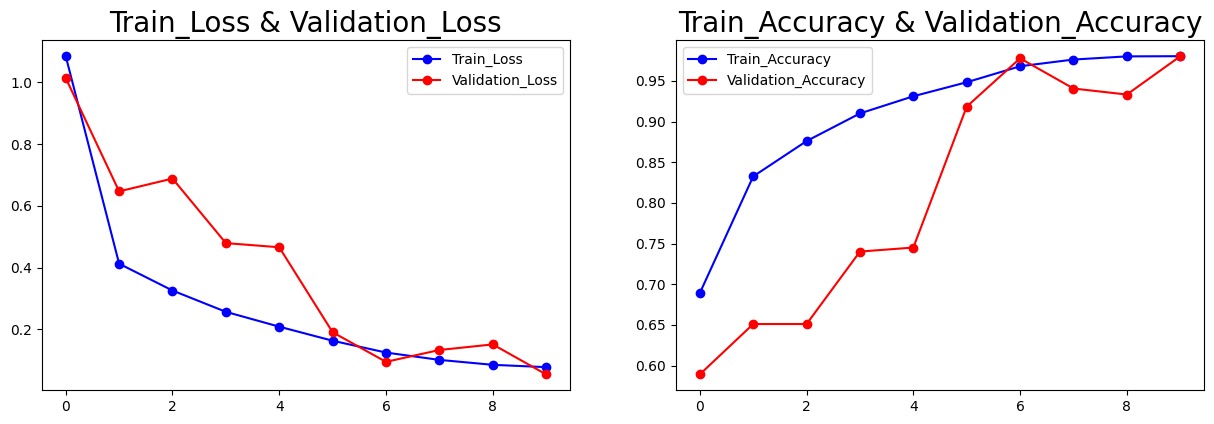

In [14]:
# Access the training history correctly
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(fine_tuned_resnet_history.history['loss'],'b-o',label='Train_Loss') # Use history.history to access the metrics
plt.plot(fine_tuned_resnet_history.history['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(fine_tuned_resnet_history.history['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(fine_tuned_resnet_history.history['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
# Check if 'specificity_at_sensitivity' and 'auc' are available in your history
# Changed 'history' to 'fine_tuned_resnet_history'
if 'specificity_at_sensitivity' in fine_tuned_resnet_history.history:
    plt.subplot(2,2,3)
    plt.plot(fine_tuned_resnet_history.history['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
    plt.plot(fine_tuned_resnet_history.history['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
    plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
    plt.legend()
if 'auc' in fine_tuned_resnet_history.history:
    plt.subplot(2,2,4)
    plt.plot(fine_tuned_resnet_history.history['auc'],'b-o',label='Train_auc')
    plt.plot(fine_tuned_resnet_history.history['val_auc'],'r-o',label='Validation_auc')
    plt.title('Train_AUC & Validation_AUC',fontsize=20)
    plt.legend()
plt.show()

In [16]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-10:]:
    layer.trainable = True

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=10, validation_data=val_generator)


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 81s 527ms/step - accuracy: 0.5935 - loss: 0.6842 - val_accuracy: 0.8960 - val_loss: 0.3118
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 62s 481ms/step - accuracy: 0.9093 - loss: 0.2263 - val_accuracy: 0.9851 - val_loss: 0.0603
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 63s 486ms/step - accuracy: 0.9813 - loss: 0.0645 - val_accuracy: 0.9926 - val_loss: 0.0352
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 63s 484ms/step - accuracy: 0.9916 - loss: 0.0238 - val_accuracy: 1.0000 - val_loss: 8.4917e-04
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 83s 488ms/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 0.9926 - val_loss: 0.0343
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 62s 481ms/step - accuracy: 0.9908 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 0.0146
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 63s 484ms/step - accuracy: 0.9922 - loss: 0.0218 - val_accuracy: 0.9950 - val_loss: 0.0129
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 63s 484ms/step - accuracy: 0.9994 - los

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
# Evaluate ResNet50 model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

# Predictions and metrics for the test set
test_preds = model.predict(test_generator)
test_preds = (test_preds > 0.5).astype(int)

test_labels = test_generator.classes

print('Classification Report')
print(classification_report(test_labels, test_preds, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
print(confusion_matrix(test_labels, test_preds))

accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)

print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 781ms/step - accuracy: 0.9864 - loss: 0.0594
Test loss: 0.03785131126642227
Test accuracy: 0.9899749159812927
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step
Classification Report
               precision    recall  f1-score   support

    fractured       1.00      0.98      0.99       199
not fractured       0.98      1.00      0.99       200

     accuracy                           0.99       399
    macro avg       0.99      0.99      0.99       399
 weighted avg       0.99      0.99      0.99       399

Confusion Matrix
[[195   4]
 [  0 200]]
Accuracy: 0.9899749373433584
F1 score: 0.9900990099009901
Precision: 0.9803921568627451
Recall: 1.0


In [19]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# Build a CNN model from scratch
image_size = (224, 224)
img_height, img_width = image_size
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Increased dropout rate

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Increased dropout rate

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.35),  # Increased dropout rate

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Added L2 regularization
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model before training
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) # Added this line to compile the model

# Updated callbacks with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_history = cnn_model.fit(
    train_generator,
    epochs=10,  # More epochs
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 33s 200ms/step - accuracy: 0.7717 - loss: 1.6005 - val_accuracy: 0.5891 - val_loss: 1.9387
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9184 - loss: 1.2012 - val_accuracy: 0.5891 - val_loss: 1.7752
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9504 - loss: 1.0775 - val_accuracy: 0.5990 - val_loss: 3.1549
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.9625 - loss: 1.0019 - val_accuracy: 0.6064 - val_loss: 4.3147
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.9777 - loss: 0.9188 - val_accuracy: 0.6436 - val_loss: 4.2919
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.9812 - loss: 0.8563 - val_accuracy: 0.6609 - val_loss: 4.1335
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.9871 - loss: 0.7969 - val_accuracy: 0.6584 - val_loss: 4.3262


In [20]:
# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

# Predictions and metrics for the test set
test_preds = cnn_model.predict(test_generator)
test_preds = (test_preds > 0.5).astype(int)
test_labels = test_generator.classes

print('Classification Report')
print(classification_report(test_labels, test_preds, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
print(confusion_matrix(test_labels, test_preds))

accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)

print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.5986 - loss: 1.7623
Test loss: 1.7862365245819092
Test accuracy: 0.6140350699424744
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step
Classification Report
               precision    recall  f1-score   support

    fractured       0.61      0.62      0.62       199
not fractured       0.62      0.60      0.61       200

     accuracy                           0.61       399
    macro avg       0.61      0.61      0.61       399
 weighted avg       0.61      0.61      0.61       399

Confusion Matrix
[[124  75]
 [ 79 121]]
Accuracy: 0.6140350877192983
F1 score: 0.6111111111111112
Precision: 0.6173469387755102
Recall: 0.605


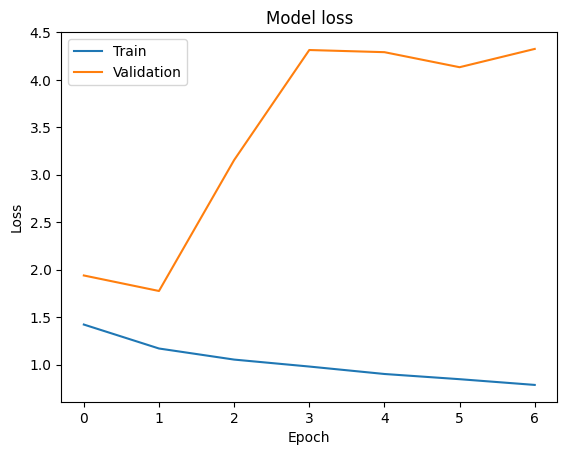

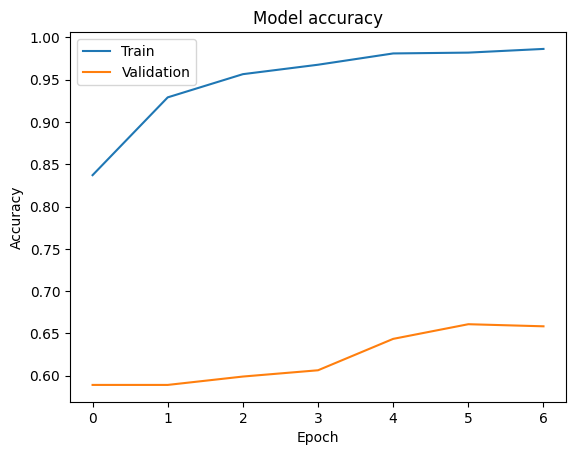

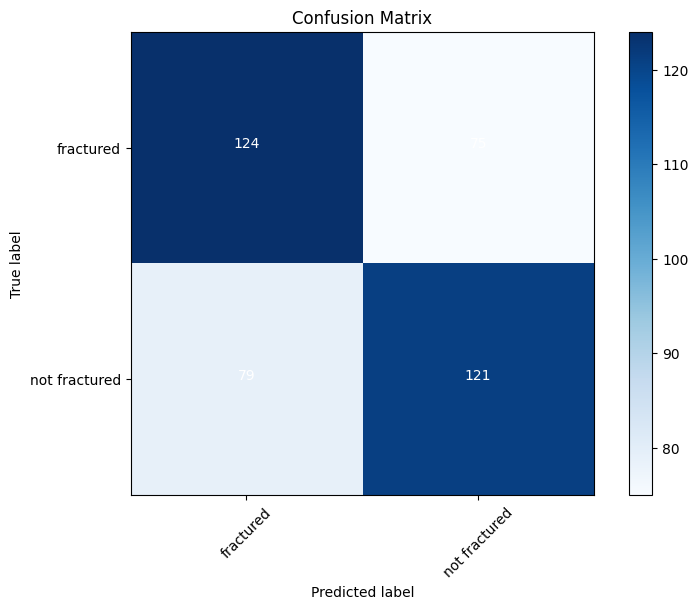

In [21]:
# prompt: visualize the metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

# Plot training & validation loss values
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


        Model  Accuracy  Validation Accuracy      Loss  Validation Loss
0  Custom CNN  0.986408             0.658416  0.785223         4.326210
1       VGG16  0.991748             0.997525  0.022085         0.010244
2    ResNet50  0.980340             0.980198  0.077367         0.054001


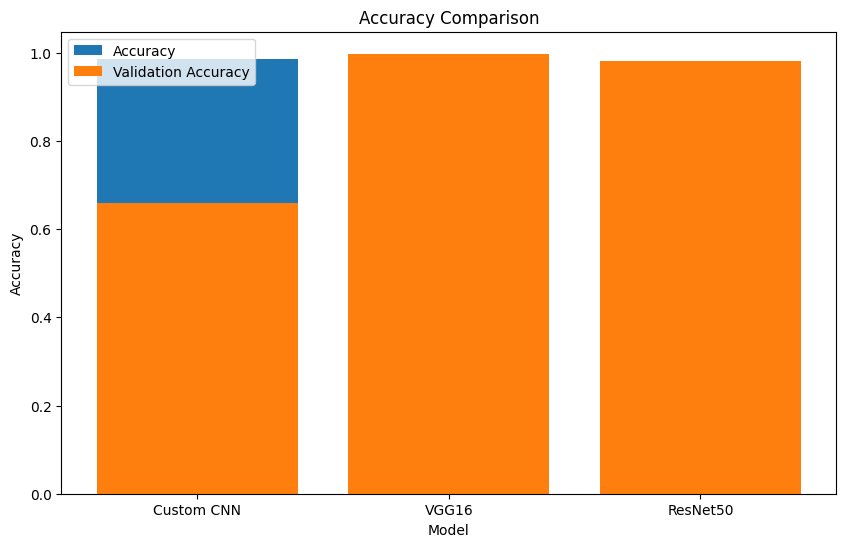

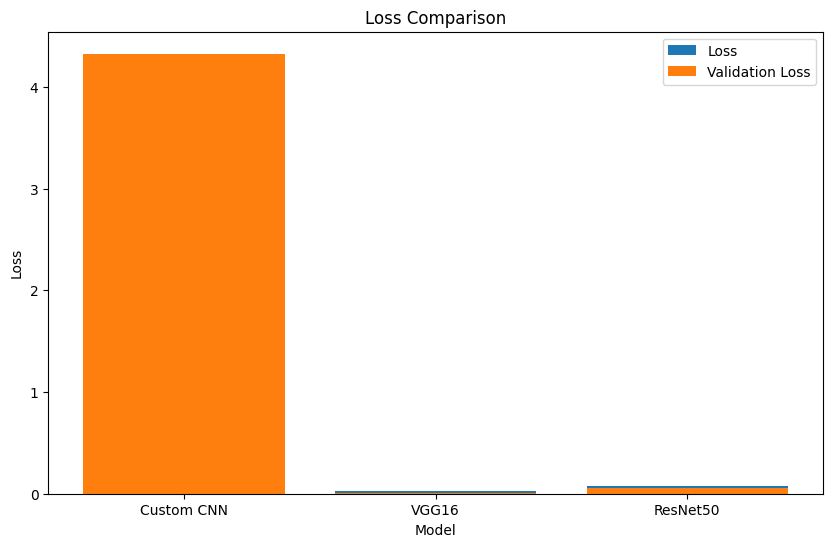

In [22]:
# prompt: visualize the metrics and compare all three models

import pandas as pd
# Extract metrics for each model
cnn_accuracy = cnn_history.history['accuracy'][-1]
cnn_val_accuracy = cnn_history.history['val_accuracy'][-1]
cnn_loss = cnn_history.history['loss'][-1]
cnn_val_loss = cnn_history.history['val_loss'][-1]

vgg_accuracy = history.history['accuracy'][-1]
vgg_val_accuracy = history.history['val_accuracy'][-1]
vgg_loss = history.history['loss'][-1]
vgg_val_loss = history.history['val_loss'][-1]

resnet_accuracy = fine_tuned_resnet_history.history['accuracy'][-1]
resnet_val_accuracy = fine_tuned_resnet_history.history['val_accuracy'][-1]
resnet_loss = fine_tuned_resnet_history.history['loss'][-1]
resnet_val_loss = fine_tuned_resnet_history.history['val_loss'][-1]

# Create a DataFrame for comparison
metrics_df = pd.DataFrame({
    'Model': ['Custom CNN', 'VGG16', 'ResNet50'],
    'Accuracy': [cnn_accuracy, vgg_accuracy, resnet_accuracy],
    'Validation Accuracy': [cnn_val_accuracy, vgg_val_accuracy, resnet_val_accuracy],
    'Loss': [cnn_loss, vgg_loss, resnet_loss],
    'Validation Loss': [cnn_val_loss, vgg_val_loss, resnet_val_loss]
})

# Display the DataFrame
print(metrics_df)

# Plotting the metrics
import matplotlib.pyplot as plt

# Accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Model'], metrics_df['Accuracy'], label='Accuracy')
plt.bar(metrics_df['Model'], metrics_df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.show()

# Loss comparison
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Model'], metrics_df['Loss'], label='Loss')
plt.bar(metrics_df['Model'], metrics_df['Validation Loss'], label='Validation Loss')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.show()

In [1]:
# Save the trained models
resnet_model.save("resnet_model.h5")
# vgg_model.save("vgg_model.h5")
cnn_model.save("cnn_model.h5")


NameError: name 'resnet_model' is not defined

In [24]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import gradio as gr

# Load trained models
resnet_model = load_model("resnet_model.h5")
cnn_model = load_model("cnn_model.h5")

# Define class names
class_names = ['Not Fractured', 'Fractured']

def preprocess_image(image):
    image = image.convert('RGB')
    image = image.resize((224, 224))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict(image, model_choice):
    img_array = preprocess_image(image)

    if model_choice == "ResNet50":
        model = resnet_model
    else:
        model = cnn_model

    prediction = model.predict(img_array)
    confidence = float(prediction[0][0])

    if confidence < 0.5:
        result = "Fractured"
        confidence_score = (1 - confidence) * 100
    else:
        result = "Not Fractured"
        confidence_score = confidence * 100

    return f"Prediction: {result} (Confidence: {confidence_score:.2f}%)"

# Define Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=[gr.Image(type="pil"), gr.Radio(["ResNet50", "CNN"], label="Select Model")],
    outputs=gr.Textbox(label="Prediction Result"),
    title="Bone Fracture Detection",
    description="Upload an X-ray image and select a model to detect bone fractures."
)

# Launch the app
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://242404893009274103.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
